In [1]:
pip install xgboost

     |████████████████████████████████| 173.6 MB 8.3 kB/s             
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


[Text(697.5, 713.475, 'smoker <= 0.5\nmse = 146416584.698\nsamples = 1070\nvalue = 13265.484'),
 Text(348.75, 509.625, 'age <= 42.5\nmse = 34549954.115\nsamples = 850\nvalue = 8351.127'),
 Text(174.375, 305.775, 'children <= 0.5\nmse = 20171998.348\nsamples = 476\nvalue = 5276.642'),
 Text(87.1875, 101.92499999999995, 'mse = 15067137.289\nsamples = 208\nvalue = 3789.007'),
 Text(261.5625, 101.92499999999995, 'mse = 21083323.893\nsamples = 268\nvalue = 6431.224'),
 Text(523.125, 305.775, 'age <= 51.5\nmse = 25507346.578\nsamples = 374\nvalue = 12264.108'),
 Text(435.9375, 101.92499999999995, 'mse = 23805473.855\nsamples = 162\nvalue = 10399.842'),
 Text(610.3125, 101.92499999999995, 'mse = 22122604.786\nsamples = 212\nvalue = 13688.689'),
 Text(1046.25, 509.625, 'bmi <= 29.972\nmse = 124801092.223\nsamples = 220\nvalue = 32252.773'),
 Text(871.875, 305.775, 'age <= 41.0\nmse = 26366123.006\nsamples = 101\nvalue = 21592.475'),
 Text(784.6875, 101.92499999999995, 'mse = 14006906.85\nsampl

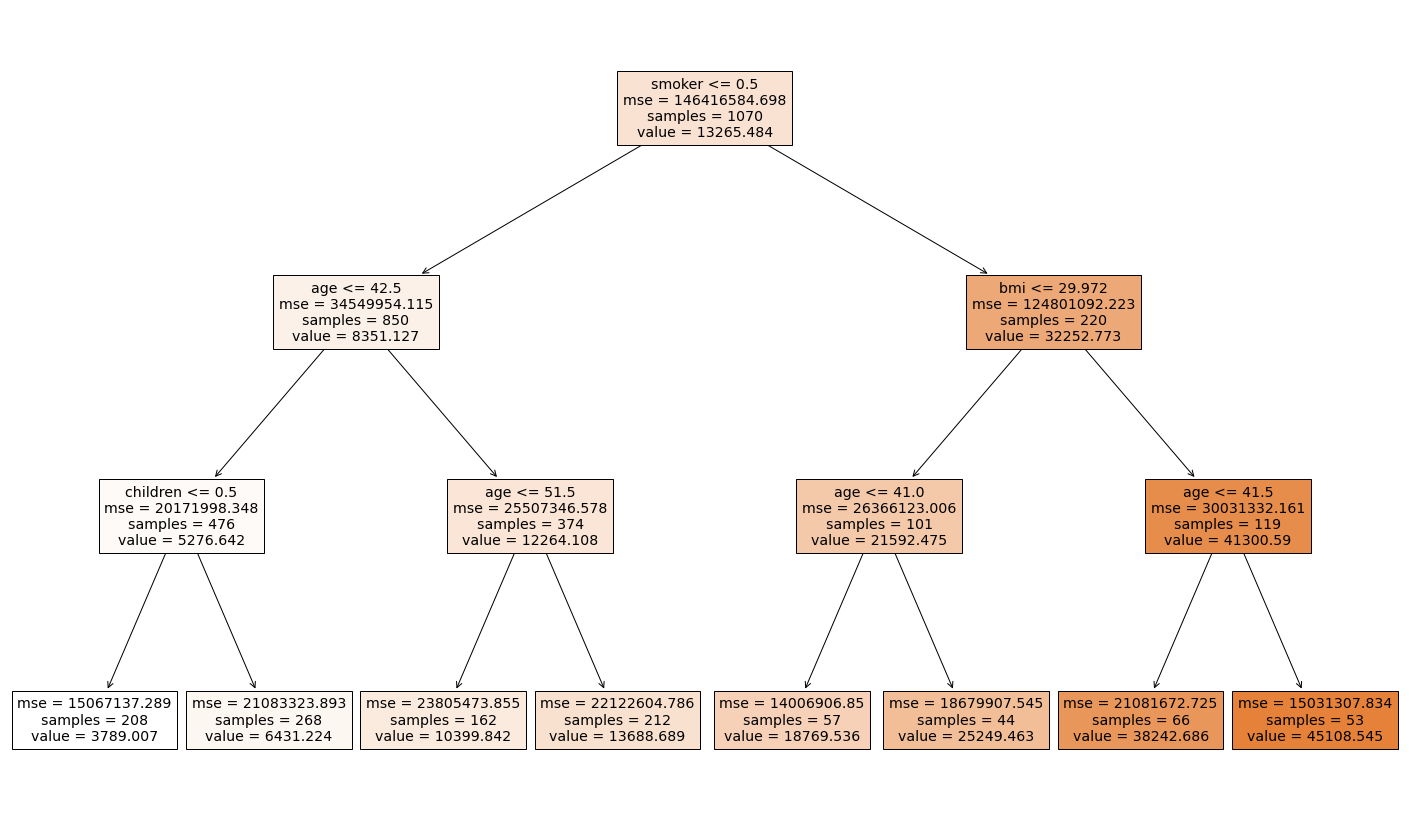

In [10]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [11]:
## Forcing to be data-frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Engineering features from decision-tree
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] <= 32.5), 1, 0)
X_train['interaction_2'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 32.5) & (X_train['age'] <= 44.5), 1, 0)
X_train['interaction_3'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 44.5) & (X_train['age'] < 51.5), 1, 0)
X_train['interaction_4'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 51.5), 1, 0)

X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] <= 32.5), 1, 0)
X_test['interaction_2'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 32.5) & (X_test['age'] <= 44.5), 1, 0)
X_test['interaction_3'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 44.5) & (X_test['age'] < 51.5), 1, 0)
X_test['interaction_4'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 51.5), 1, 0)

In [12]:
## Fitting random forest model 
RF = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test
RF_pred = RF.predict(X_test)

## Computing the mse
print(mean_squared_error(Y_test, RF_pred))

25934609.475705307


In [13]:
## Fitting the xgboost model 
xgb = XGBRegressor(booster = 'gbtree', objective = 'reg:squarederror', n_estimators = 500, max_depth = 3, learning_rate = 0.01, n_jobs = -1).fit(X_train, Y_train)

## Predicting on the test 
xgb_pred = xgb.predict(X_test)

## Computing the mse
print(mean_squared_error(Y_test, xgb_pred))

25831857.155266505
